[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Dataset shape: (5574, 2)
label
ham     4827
spam     747
Name: count, dtype: int64
Saved cleaned data to /content/SMSSpamCollection_cleaned.csv


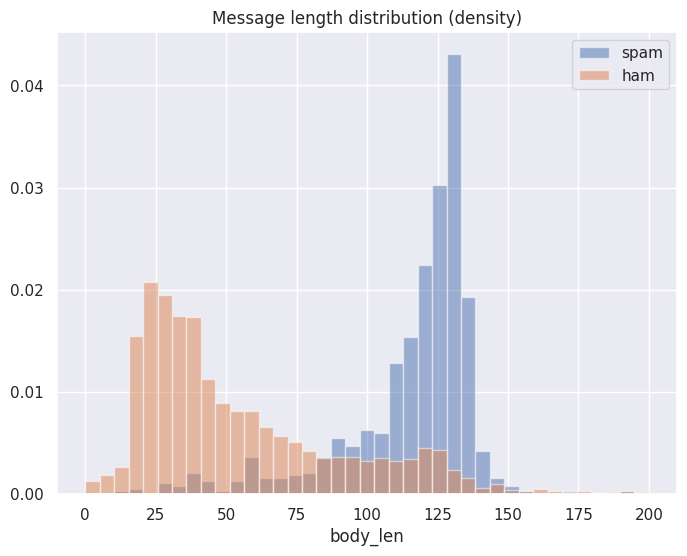

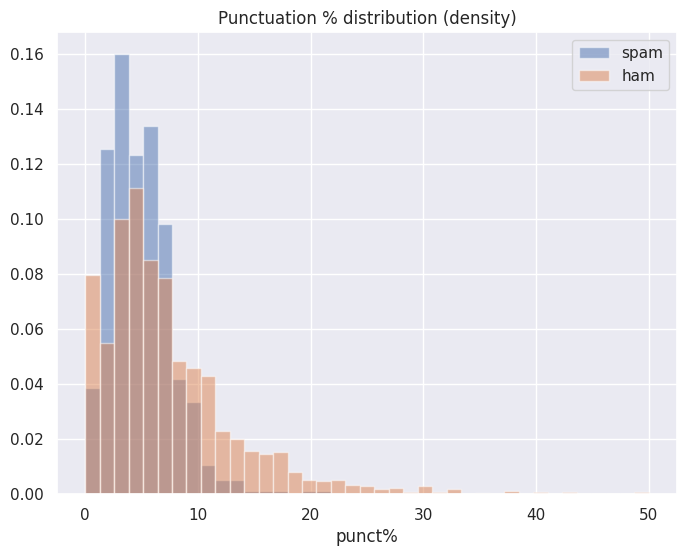

X_train_vect shape: (4459, 6672) X_test_vect shape: (1115, 6672)
Example column name types (first 10): [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]

Training RandomForest ...

RandomForest metrics (spam as positive class):
Precision: 0.9921  Recall: 0.8389  F1: 0.9091  Accuracy: 97.76%

Classification report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



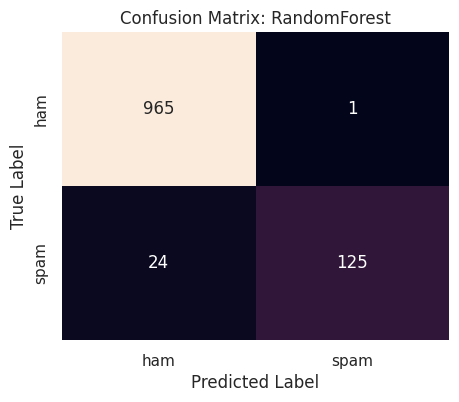


Training GradientBoosting ...

GradientBoosting metrics (spam as positive class):
Precision: 0.8978  Recall: 0.8255  F1: 0.8601  Accuracy: 96.41%

Classification report:
               precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.90      0.83      0.86       149

    accuracy                           0.96      1115
   macro avg       0.94      0.91      0.92      1115
weighted avg       0.96      0.96      0.96      1115



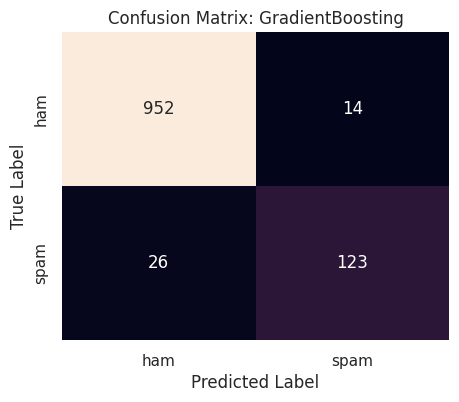


Model comparison (sorted by f1 on spam):
              model  precision_spam  recall_spam  f1_spam  accuracy
0      RandomForest          0.9921       0.8389   0.9091    0.9776
1  GradientBoosting          0.8978       0.8255   0.8601    0.9641

Best model by F1 (spam): RandomForest
Saved best model and TF-IDF vectorizer to current directory.

Script finished.


In [5]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk

# ---------- Ensure NLTK resources are available ----------
nltk_packages = ["stopwords", "punkt", "wordnet", "omw-1.4"]
for pkg in nltk_packages:
    try:
        nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        nltk.download(pkg)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
wn = WordNetLemmatizer()

# ---------- File path (uses uploaded file location) ----------
DEFAULT_PATH = Path("/mnt/data/SMSSpamCollection.tsv")
if not DEFAULT_PATH.exists():
    DEFAULT_PATH = Path("SMSSpamCollection.tsv")  # fallback

if not DEFAULT_PATH.exists():
    raise FileNotFoundError(f"Could not find SMSSpamCollection.tsv at {DEFAULT_PATH}. Please place file there.")

# ---------- Read dataset ----------
data = pd.read_csv(DEFAULT_PATH, sep="\t", names=["label", "body_text"], header=None, quoting=3)
print("Dataset shape:", data.shape)
print(data["label"].value_counts())

# ---------- Basic cleaning helpers ----------
def safe_text(x):
    if pd.isna(x):
        return ""
    return str(x)

def remove_punc(text: str) -> str:
    text = safe_text(text)
    return "".join(ch for ch in text if ch not in string.punctuation)

def tokenize(text: str) -> list:
    text = safe_text(text).lower()
    tokens = re.split(r"\W+", text)
    tokens = [t for t in tokens if t and not t.isnumeric()]
    return tokens

def remove_stopwords(tokens: list) -> list:
    return [t for t in tokens if t not in stop_words]

def do_stem(tokens: list) -> list:
    return [ps.stem(t) for t in tokens]

def do_lemmatize(tokens: list) -> list:
    return [wn.lemmatize(t) for t in tokens]

# ---------- Apply preprocessing columns ----------
data["body_text_clean"] = data["body_text"].apply(remove_punc)
data["body_text_tokenized"] = data["body_text_clean"].apply(tokenize)
data["body_text_nonstop"] = data["body_text_tokenized"].apply(remove_stopwords)
data["body_text_stemmed"] = data["body_text_nonstop"].apply(do_stem)
data["body_text_lemmatized"] = data["body_text_nonstop"].apply(do_lemmatize)

# ---------- Save cleaned CSV (optional) ----------
out_clean_path = Path.cwd() / "SMSSpamCollection_cleaned.csv"
data.to_csv(out_clean_path, index=False)
print(f"Saved cleaned data to {out_clean_path}")

# ---------- Vectorization helpers ----------
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def clean_text_for_vectorizer(text):
    text = safe_text(text).lower()
    text = "".join(ch for ch in text if ch not in string.punctuation)
    tokens = re.split(r"\W+", text)
    tokens = [ps.stem(t) for t in tokens if t and t not in stop_words and not t.isnumeric()]
    return tokens

# ---------- TF-IDF (used for modeling) ----------
tfidf_vect = TfidfVectorizer(analyzer=clean_text_for_vectorizer)

# ---------- Feature engineering: length & punctuation % ----------
data['body_len'] = data['body_text'].apply(lambda x: len(safe_text(x)) - safe_text(x).count(" "))

def count_punct_pct(text):
    text = safe_text(text)
    total_chars = len(text) - text.count(" ")
    if total_chars <= 0:
        return 0.0
    punct_count = sum(1 for ch in text if ch in string.punctuation)
    return round((punct_count / total_chars) * 100, 3)

data['punct%'] = data['body_text'].apply(count_punct_pct)

# ---------- Quick EDA plots (optional) ----------
sns.set(rc={"figure.figsize": (8, 6)})
bins = np.linspace(0, 200, 40)
plt.hist(data[data['label'] == 'spam']['body_len'], bins, alpha=0.5, density=True, label='spam')
plt.hist(data[data['label'] == 'ham']['body_len'], bins, alpha=0.5, density=True, label='ham')
plt.legend(loc='upper right')
plt.title("Message length distribution (density)")
plt.xlabel("body_len")
plt.show()

bins = np.linspace(0, 50, 40)
plt.hist(data[data['label'] == 'spam']['punct%'], bins, alpha=0.5, density=True, label='spam')
plt.hist(data[data['label'] == 'ham']['punct%'], bins, alpha=0.5, density=True, label='ham')
plt.legend(loc='upper right')
plt.title("Punctuation % distribution (density)")
plt.xlabel("punct%")
plt.show()

# ---------- Train/test split ----------
from sklearn.model_selection import train_test_split
X = data[['body_text', 'body_len', 'punct%']].copy()
y = data['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ---------- Fit TF-IDF on train and transform ----------
tfidf_vect = TfidfVectorizer(analyzer=clean_text_for_vectorizer)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])
tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

# ---------- IMPORTANT FIX: ensure TF-IDF columns have STRING names before concatenation ----------
# Build TF-IDF dataframes with string column names like "tfidf_0", "tfidf_1", ...
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(),
                              columns=[f"tfidf_{i}" for i in range(tfidf_train.shape[1])])
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(),
                             columns=[f"tfidf_{i}" for i in range(tfidf_test.shape[1])])

# Now concatenate engineered features (string named) with tfidf (string named)
X_train_vect = pd.concat([
    X_train[['body_len', 'punct%']].reset_index(drop=True),
    tfidf_train_df.reset_index(drop=True)
], axis=1)

X_test_vect = pd.concat([
    X_test[['body_len', 'punct%']].reset_index(drop=True),
    tfidf_test_df.reset_index(drop=True)
], axis=1)

# Confirm all column names are strings
X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)

print("X_train_vect shape:", X_train_vect.shape, "X_test_vect shape:", X_test_vect.shape)
print("Example column name types (first 10):", [type(c) for c in X_train_vect.columns[:10]])

# ---------- Train & evaluate models: Random Forest + Gradient Boosting ----------
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix, classification_report

models = {
    "RandomForest": RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name} ...")
    # Use pandas DataFrame with string column names; sklearn accepts it now
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)

    precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
    accuracy = acs(y_test, y_pred)
    results.append({
        "model": name,
        "precision_spam": round(precision, 4),
        "recall_spam": round(recall, 4),
        "f1_spam": round(fscore, 4),
        "accuracy": round(accuracy, 4)
    })

    print(f"\n{name} metrics (spam as positive class):")
    print(f"Precision: {precision:.4f}  Recall: {recall:.4f}  F1: {fscore:.4f}  Accuracy: {accuracy*100:.2f}%")

    # classification report
    print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=["ham", "spam"]))

    # confusion matrix plot
    cm = confusion_matrix(y_test, y_pred, labels=["ham", "spam"])
    df_cm = pd.DataFrame(cm, index=["ham", "spam"], columns=["ham", "spam"])
    plt.figure(figsize=(5,4))
    sns.heatmap(df_cm, annot=True, fmt='d', cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# ---------- Summary comparison table ----------
results_df = pd.DataFrame(results).sort_values("f1_spam", ascending=False).reset_index(drop=True)
print("\nModel comparison (sorted by f1 on spam):")
print(results_df)

# ---------- Optional: save best model and vectorizer ----------
best_model_name = results_df.loc[0, "model"]
print(f"\nBest model by F1 (spam): {best_model_name}")

import joblib
joblib.dump(models[best_model_name], f"{best_model_name}_model.joblib")
joblib.dump(tfidf_vect_fit, "tfidf_vectorizer.joblib")
print("Saved best model and TF-IDF vectorizer to current directory.")

print("\nScript finished.")
